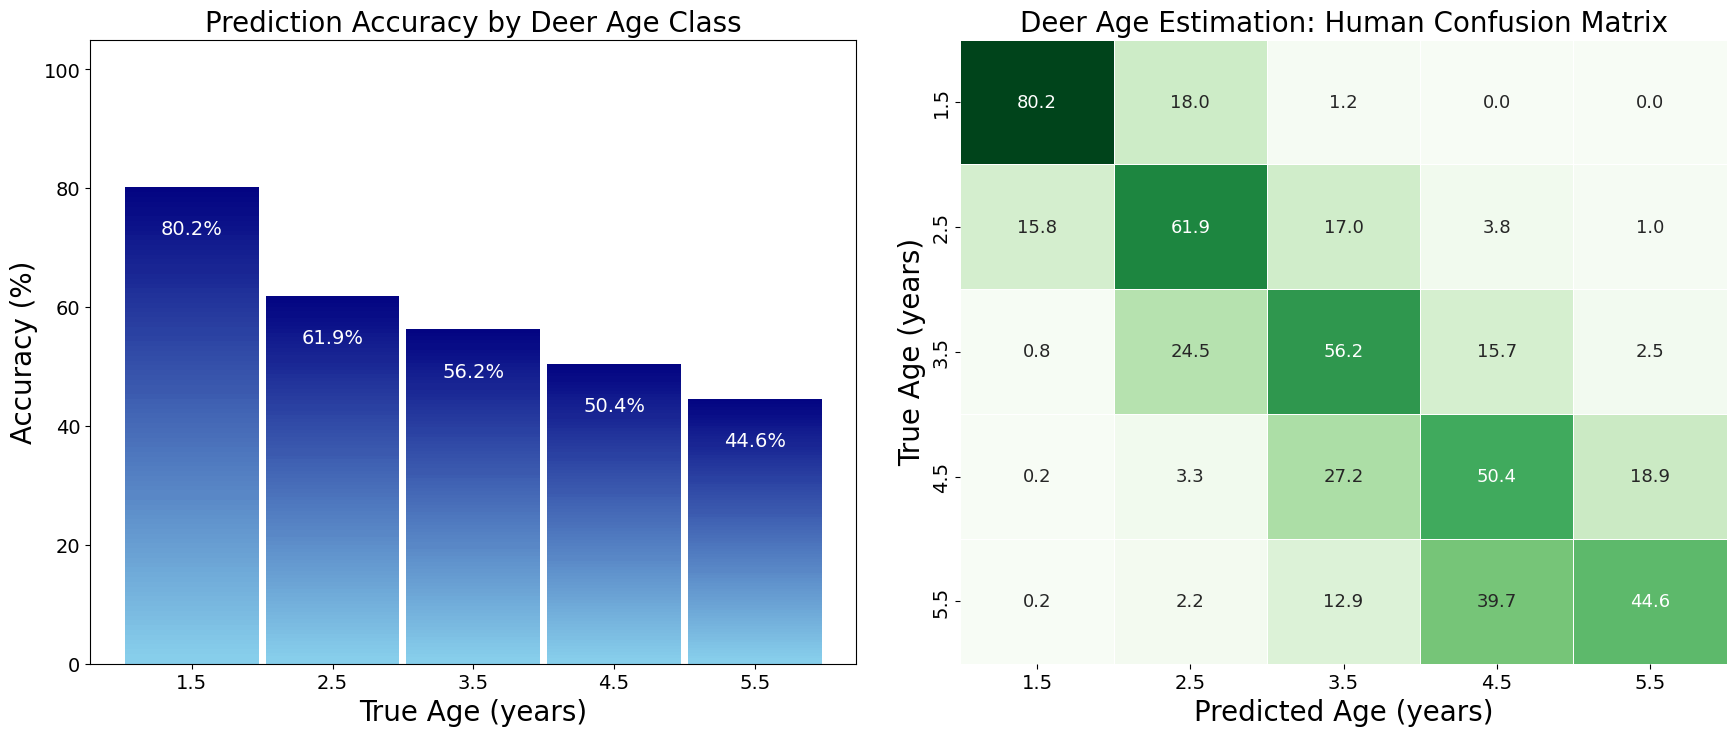

Individual Accuracy: 58.88%
Within-One-Age Accuracy: 94.37%
Majority Vote Accuracy: 76.27%
MAE: nan years

Accuracy by Age Class:
   Age  Accuracy (%)  Sample Count
0  1.5     80.166667             6
1  2.5     61.875000             8
2  3.5     56.250000            20
3  4.5     50.400000            10
4  5.5     44.571429            14


(array([[80.16666667, 18.        ,  1.16666667,  0.        ,  0.        ],
        [15.75      , 61.875     , 17.        ,  3.75      ,  1.        ],
        [ 0.8       , 24.5       , 56.25      , 15.65      ,  2.55      ],
        [ 0.2       ,  3.3       , 27.2       , 50.4       , 18.9       ],
        [ 0.21428571,  2.21428571, 12.85714286, 39.71428571, 44.57142857]]),
 np.float64(0.5888465261924968),
 np.float64(0.9436732840119996),
 0.7627118644067796,
 nan)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def create_confusion_matrix(data_file, output_file_prefix='deer_analysis'):
    """
    Creates a confusion matrix and accuracy bar chart from deer age estimation data.
    
    Parameters:
    data_file (str): Path to the CSV file containing the data table
    output_file_prefix (str): Prefix for saving output visualizations
    
    CSV format should have columns: 
    - 1.5, 2.5, 3.5, 4.5, 5.5 (percentage of votes for each age)
    - Correct (the correct age)
    """
    # Read the data
    df = pd.read_csv(data_file)
    
    # Age classes
    age_classes = [1.5, 2.5, 3.5, 4.5, 5.5]
    
    # Initialize confusion matrix
    confusion_matrix = np.zeros((5, 5))
    
    # Group data by correct age and calculate average vote distribution
    for i, true_age in enumerate(age_classes):
        # Filter rows with this true age
        filtered = df[df['Correct'] == true_age]
        
        if len(filtered) > 0:
            # Calculate the average percentage for each predicted age
            for j, pred_age in enumerate(age_classes):
                confusion_matrix[i, j] = filtered[str(pred_age)].mean()
    
   
    # Calculate prediction accuracy by age class
    accuracy_by_age = []
    for i, age in enumerate(age_classes):
        # Accuracy is the diagonal element (correct predictions)
        accuracy_by_age.append({
            'Age': age,
            'Accuracy': confusion_matrix[i, i]
        })
    
    # Create a dataframe for the bar chart
    accuracy_df = pd.DataFrame(accuracy_by_age)
    
    # Create the visualization
    plt.figure(figsize=(18,8))
    plt.subplot(1,2,1)   
    
    # Create custom blue gradient colormap (navy to light blue)
    colors = ['#000080', '#87CEEB']  # Navy blue to light blue
    n_bins = 100
    blue_gradient = LinearSegmentedColormap.from_list('blue_gradient', colors, N=n_bins)
    
    # Create bars with gradient effect
    bars = plt.bar(range(len(accuracy_df)), accuracy_df['Accuracy'], 
                   linewidth=0, edgecolor='none', width=0.8)
    
    # Apply gradient to each bar
    for i, bar in enumerate(bars):
        height = bar.get_height()
        # Create gradient effect by dividing each bar into segments
        y_segments = np.linspace(0, height, n_bins)
        for j in range(len(y_segments)-1):
            segment_height = y_segments[j+1] - y_segments[j]
            color_intensity = 1 - (j / len(y_segments))  # Darker at top, lighter at bottom
            color = blue_gradient(color_intensity)
            plt.bar(i, segment_height, bottom=y_segments[j], 
                   color=color, linewidth=0, edgecolor='none', width=0.95)
    
    # Add white value labels within each bar near the top
    for index, row in accuracy_df.iterrows():
        plt.text(index, row['Accuracy'] - 8, f"{row['Accuracy']:.1f}%", 
                color='white', ha='center', fontsize=14)
    
    plt.title('Prediction Accuracy by Deer Age Class', fontsize=20)
    plt.xlabel('True Age (years)', fontsize=20)
    plt.ylabel('Accuracy (%)', fontsize=20)
    plt.ylim(0, 105)  # Set y-axis limit to leave room for labels
    plt.xticks(range(len(age_classes)), age_classes, fontsize=14)
    plt.yticks(fontsize=14)

    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 13}, fmt='.1f', cmap='Greens',
                xticklabels=age_classes, yticklabels=age_classes, linewidths=0.5, cbar=False)
    
    plt.title('Deer Age Estimation: Human Confusion Matrix', fontsize=20)
    plt.xlabel('Predicted Age (years)', fontsize=20)
    plt.ylabel('True Age (years)', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Save the bar chart
    plt.tight_layout(pad=3.0)  # Increase padding between subplots
    plt.show()
    
    # Calculate metrics
    diagonal_sum = np.trace(confusion_matrix)
    total_sum = np.sum(confusion_matrix)
    accuracy = diagonal_sum / total_sum
    
    # Calculate within-one accuracy
    within_one = 0
    for i in range(5):
        for j in range(5):
            if abs(i - j) <= 1:  # If within one age class
                within_one += confusion_matrix[i, j]
    
    within_one_accuracy = within_one / total_sum
    
    # Calculate majority vote accuracy by examining each row
    majority_correct = 0
    total_rows = len(df)
    
    for _, row in df.iterrows():
        true_age = row['Correct']
        votes = [row[str(age)] for age in age_classes]
        majority_pred = age_classes[np.argmax(votes)]
        if majority_pred == true_age:
            majority_correct += 1
    
    majority_accuracy = majority_correct / total_rows
    
    # Calculate MAE
    mae = calculate_mae(df, age_classes)
    
    # Print metrics
    print(f"Individual Accuracy: {accuracy:.2%}")
    print(f"Within-One-Age Accuracy: {within_one_accuracy:.2%}")
    print(f"Majority Vote Accuracy: {majority_accuracy:.2%}")
    print(f"MAE: {mae:.2f} years")
    
    # Create a summary table
    accuracy_summary = pd.DataFrame({
        'Age': age_classes,
        'Accuracy (%)': [confusion_matrix[i, i] for i in range(5)],
        'Sample Count': [len(df[df['Correct'] == age]) for age in age_classes]
    })
    
    print("\nAccuracy by Age Class:")
    print(accuracy_summary)
    
    return confusion_matrix, accuracy, within_one_accuracy, majority_accuracy, mae

def calculate_mae(df, age_classes):
    """Calculate Mean Absolute Error for the dataset"""
    total_error = 0
    total_samples = 0
    
    for _, row in df.iterrows():
        true_age = row['Correct']
        weighted_error = 0
        
        for age in age_classes:
            # Weight by percentage of votes
            weighted_error += abs(age - true_age) * (row[str(age)] / 100)
        
        total_error += weighted_error
        total_samples += 1
    
    return total_error / total_samples

# Example usage
create_confusion_matrix('../image_metadata.csv')